# Week09 Performance Evaluation, Encsemble Methods

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

---
p4

# 1. Model Evaluation and Hyperparameter Tuning

### Loading Breast Cancer Dataset

In [2]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
df.shape

(569, 32)

In [4]:
from sklearn.preprocessing import LabelEncoder

# Get X, y. Encoding class label with scikit-learn
X = df.loc[:, 2:].values # remove 1st column(ID) & 2nd column(target)
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

X.shape

(569, 30)

In [5]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)
X_train.shape

(455, 30)

---
p5

### Combining transformers and estimators in a pipeline

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline

# make pipeline
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
'''
# Instead you can use Pipeline class
pipe_lr = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('PCA', PCA(n_components=2)),
    ('LR', LogisticRegression(random_state=1))
])
'''

# process using pipeline
pipe_lr.fit(X_train, y_train)

print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


---
p7

### Using k-fold cross validation to assess model performance

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    
# make indices for stratified k-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=False).split(X,y)

# train and compute test score for each set
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X[train], y[train])
    score = pipe_lr.score(X[test], y[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [286 169], Acc: 0.939
Fold:  2, Class dist.: [286 169], Acc: 0.947
Fold:  3, Class dist.: [285 170], Acc: 0.939
Fold:  4, Class dist.: [285 170], Acc: 0.947
Fold:  5, Class dist.: [286 170], Acc: 0.982

CV accuracy: 0.951 +/- 0.016


---
p8

In [8]:
from sklearn.model_selection import cross_val_score

# cross validation using cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X, y=y, cv=5, n_jobs=1)
print('Scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Scores: [0.93859649 0.94736842 0.93859649 0.94736842 0.98230088]
CV accuracy: 0.951 +/- 0.016


---
p10

### Checking performance with learning curves

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", random_state=1, max_iter=500))

# accuracies for different training set size
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                X=X,
                y=y,
                train_sizes=np.linspace(0.1,1.0,10),
                cv=10,
                n_jobs=1)
print(train_sizes)
print(train_scores.shape)

[ 51 102 153 204 256 307 358 409 460 512]
(10, 10)


---
p11

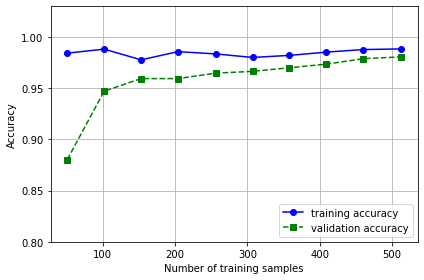

In [10]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o', 
         label='training accuracy')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--', marker='s', 
         label='validation accuracy')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()

plt.show()

---
p12

### Checking overfitting and underfitting with validation curves

In [11]:
from sklearn.model_selection import validation_curve

# accuracies for different regularization parameters
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name="logisticregression__C",
                                             param_range=param_range,
                                             cv=10)

print(param_range)
print(train_scores.shape)

[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
(6, 10)


---
p13

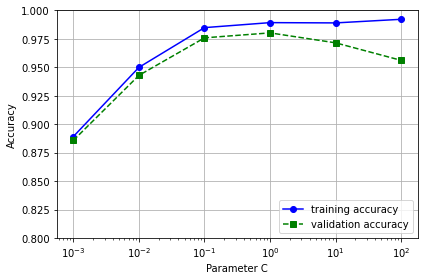

In [12]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         label='training accuracy')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', marker='s',
         label='validation accuracy')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()

plt.show()

---
p14

### Tuning hyperparameters via grid search

In [13]:
from sklearn.model_selection import GridSearchCV

stdsc = StandardScaler()
X = stdsc.fit_transform(X)

# training with various parameter combinations
param_grid = [{"C":[0.01,0.1,1.0,10.0,100.0],
               "penalty":["l1","l2"]}]

gs = GridSearchCV(estimator=LogisticRegression(),
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=5,
                 n_jobs=1)
gs = gs.fit(X,y)

means =  gs.cv_results_["mean_test_score"]
stds = gs.cv_results_["std_test_score"]
params = gs.cv_results_["params"]
for mean, std, params in zip(means, stds, params):
    print("%0.3f (+/-%0.3f) for %s" % (mean, std * 2, params))

print()
print("Best score:", gs.best_score_)
print("Parameters:", gs.best_params_)

nan (+/-nan) for {'C': 0.01, 'penalty': 'l1'}
0.949 (+/-0.026) for {'C': 0.01, 'penalty': 'l2'}
nan (+/-nan) for {'C': 0.1, 'penalty': 'l1'}
0.975 (+/-0.013) for {'C': 0.1, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1.0, 'penalty': 'l1'}
0.981 (+/-0.013) for {'C': 1.0, 'penalty': 'l2'}
nan (+/-nan) for {'C': 10.0, 'penalty': 'l1'}
0.970 (+/-0.028) for {'C': 10.0, 'penalty': 'l2'}
nan (+/-nan) for {'C': 100.0, 'penalty': 'l1'}
0.963 (+/-0.037) for {'C': 100.0, 'penalty': 'l2'}

Best score: 0.9806862288464524
Parameters: {'C': 1.0, 'penalty': 'l2'}


In [14]:
# the best model
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.947


---
p19

### Confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[68  4]
 [ 2 40]]


### Precision, Recall, and F1

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.909
Recall: 0.952
F1: 0.930


---
p20

### ROC (Receiver Operating Characteristic) Curve

In [17]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty="l2", random_state=1,C=0.1))

X_train2 = X_train[:, [4, 5]]
X_test2 = X_test[:, [4, 5]]

# prediction probability of class 1
pipe_lr.fit(X_train2, y_train)
probas = pipe_lr.predict_proba(X_test2)
probas[:,1]

array([0.53282813, 0.15817061, 0.51812577, 0.62892811, 0.41243482,
       0.43835836, 0.85533439, 0.34034951, 0.30733992, 0.08722417,
       0.13427872, 0.12640791, 0.95258984, 0.24971451, 0.66494577,
       0.50358049, 0.41915744, 0.07711583, 0.35712582, 0.31808809,
       0.26497807, 0.13998129, 0.12122886, 0.22064399, 0.85111068,
       0.30019008, 0.16914113, 0.51529561, 0.11526452, 0.16904096,
       0.14380837, 0.12175567, 0.1401703 , 0.22201786, 0.1010705 ,
       0.14245774, 0.12708304, 0.22968424, 0.19157186, 0.72612174,
       0.51402239, 0.45798558, 0.19332654, 0.53958541, 0.16523808,
       0.07525642, 0.81934357, 0.21744893, 0.34394163, 0.403577  ,
       0.22400003, 0.56529082, 0.23914355, 0.09923984, 0.22327367,
       0.40496427, 0.52473711, 0.37463394, 0.31377216, 0.77230777,
       0.10076891, 0.51846562, 0.51972376, 0.04040745, 0.08909317,
       0.99068404, 0.42437102, 0.10225292, 0.66976056, 0.16887582,
       0.93883695, 0.11107202, 0.45303914, 0.15075154, 0.58909

---
p21

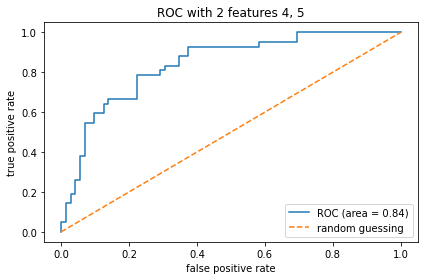

In [18]:
# FPR, TPR, AUC
fpr, tpr, thresholds = roc_curve(y_test,probas[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 
         label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         label='random guessing')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('ROC with 2 features 4, 5')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

---
p24

# 2. Ensemble Methods

### Loading Wine Dataset

In [19]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Malic acid']].values

X.shape

(119, 2)

---
p25

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1,
                                                    stratify=y)
X_train.shape

(95, 2)

---
p26

### Bagging

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=4,
                              random_state=1)
tree.fit(X_train, y_train)

# bag of trees classifier
bag = BaggingClassifier(base_estimator=tree, n_estimators=100,max_samples=0.5,
                        max_features=1.0, bootstrap=True, bootstrap_features=False,
                        n_jobs=1, random_state=1)
bag.fit(X_train, y_train)

print('Tree training/test accuracy: %.2f / %.2f' 
      % (tree.score(X_train, y_train), tree.score(X_test, y_test)))
print('Bag training/test accuracy: %.2f / %.2f' 
      % (bag.score(X_train, y_train), bag.score(X_test, y_test)))

Tree training/test accuracy: 0.92 / 0.79
Bag training/test accuracy: 0.92 / 0.88


---
p27

In [23]:
# A function for plotting decision regions
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

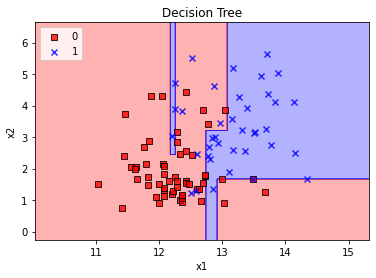

In [24]:
# decision boundary of the tree 
plot_decision_regions(X_train, y_train, classifier=tree)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Decision Tree")
plt.legend(loc='upper left')
plt.show()

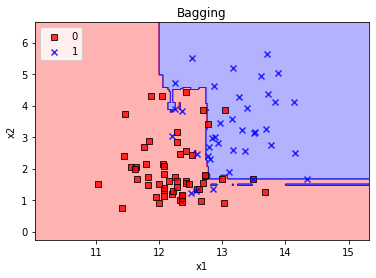

In [25]:
# decision boundary of the bag of trees classifier
plot_decision_regions(X_train, y_train, classifier=bag)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Bagging")
plt.legend(loc='upper left')
plt.show()

---
p30

### Boosting

In [26]:
from sklearn.ensemble import AdaBoostClassifier

# decision tree classifier
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)
tree.fit(X_train, y_train)

# boosting classifier
ada = AdaBoostClassifier(base_estimator=tree,n_estimators=100,learning_rate=0.1, random_state=1)
ada.fit(X_train, y_train)

print('Tree training/test accuracy: %.2f / %.2f' 
      % (tree.score(X_train, y_train), tree.score(X_test, y_test)))
print('AdaBoost training/test accuracy: %.2f / %.2f' 
      % (ada.score(X_train, y_train), ada.score(X_test, y_test)))

Tree training/test accuracy: 0.85 / 0.75
AdaBoost training/test accuracy: 0.93 / 0.88


---
p31

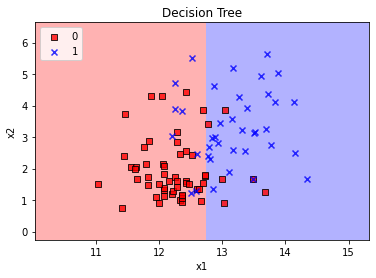

In [27]:
# decision boundary of the tree 
plot_decision_regions(X_train, y_train, classifier=tree)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Decision Tree")
plt.legend(loc='upper left')
plt.show()

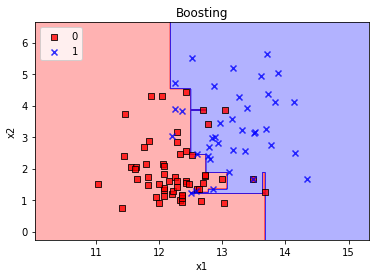

In [28]:
# decision boundary of the boosting classifier
plot_decision_regions(X_train, y_train, classifier=ada)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title("Boosting")
plt.legend(loc='upper left')
plt.show()

---
p33

# Submit
- To make sure if you have completed this practice, Submit your practice file(Week09_givencode.ipynb) to e-class.
- **Deadline : tomorrow 11:59pm**
- Modify your ipynb file name as **“Week09_StudentNum_Name.ipynb”**
  - ```Ex) Week09_2020123456_홍길동.ipynb``` 
- You can upload this file without taking the quiz, but **homework is provided like a quiz every three weeks**, so it is recommended to take the quiz as well.

# Quiz 1 : Performance Evaluation

### Fine-tune your Logistic Regression model you build last week quiz

- On the F1-Score,
    1. Do K-fold Cross validation
    2. Plot Learning curve
    3. Plot Validation curve
    4. Find optimal hyperparameter using Grid Search
- https://www.kaggle.com/c/titanic/data

### Load Dataset

In [57]:
import pandas as pd
import numpy as np

df = pd.read_csv("titanic.csv")

In [58]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### 0. Make Pipeline
- This is the code that compresses the entire process into a pipeline.
- If you think this code complicated, then you can do preprocessing like the way we did last week, without using 'Pipeline or make_pipeline'

- **Categorical feature** :
    - **Nominal feature** : Survived(target), Sex, Embarked 
    - **Ordinal feature** : Pclass(already mapped(integer vlaue))
    - Drop : PassengerId, Name, Ticket, Cabin
    - Impute the missing values with most frequent value
- **Numeric feature**  
    - Age, SibSp, Parch, Fare
    - Impute the missing values with mean value
    - Demensionality Reduction py PCA (4 -> 2)
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = ['Age', 'SibSp', 'Parch', 'Fare' ]
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    PCA(n_components=2)
)

categorical_features = ['Embarked', 'Sex']
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(drop='first')
) # Drop the first dummy feature : Embarked_C, Sex_female

# When make pipeline with the mixed types data,
# you can use different pipeline to each column(feature) using 'ColumnTransformer'
preprocessor = ColumnTransformer(
    transformers=[
        # ('name of the process', transformer(pipeline), column list)
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('pass','passthrough',["Pclass"]) # Specify what column you want to passthrough
    ]
)

In [60]:
# Check if preprocessor works well
pd.DataFrame(preprocessor.fit_transform(df),
             columns=["PC1", "PC2",
                      "Embarked_Q", "Embarked_S", # OneHotEncoder Process by alphabet order
                      "Sex", "Pclass"]).head(3)

,PC1,PC2,Embarked_Q,Embarked_S,Sex,Pclass
0,0.028368,-0.836109,0.0,1.0,1.0,3.0
1,-0.004306,0.936163,0.0,0.0,0.0,1.0
2,-0.641404,-0.558458,0.0,1.0,0.0,3.0


### Split the dataset into train set and test set

In [61]:
## Split Dataset into train and validation set
from sklearn.model_selection import train_test_split
X = df.iloc[:, 2:]
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size=0.3,random_state=0,
                                       stratify=y)
# If you do not use Pipeline, then run the bellow code,
# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)
# X = preprocessor.transform(X)
# y = y.values

### Model : Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

# If you do not use Pipeline, then use bellow code instead,
# pipe_lr = LogisticRegression()

# process using pipeline
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.806


### Evaluation : F1-Score

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Train F1 : %.3f" % f1_score(y_train, pipe_lr.predict(X_train)))
print("Test F1 : %.3f" % f1_score(y_test, pipe_lr.predict(X_test)))

Train F1 : 0.716
Test F1 : 0.737


### 1. Do K-fold Cross validation
- K-fold cross validation to assess model performance

In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# make scorer to compute F1 score in cross_val_score function
scorer = make_scorer(f1_score, pos_label=1)

# cross validation using cross_val_score
scores = cross_val_score(estimator=pipe_lr,X=X, y=y, cv=5, n_jobs=1)
print('Scores: %s' % scores)
print('CV F1: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Scores: [0.79329609 0.79213483 0.7752809  0.78089888 0.80337079]
CV F1: 0.789 +/- 0.010


### 2. Plot Learning Curve

In [65]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=1)

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X,
                                                        y=y,
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                        cv=10,
                                                        n_jobs=1)
print(train_sizes)
print(train_scores.shape)

[ 80 160 240 320 400 480 560 640 720 801]
(10, 10)


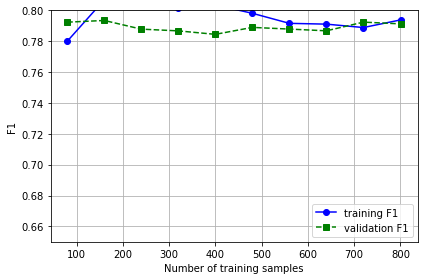

In [66]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
        color='blue', marker='o', 
        label='training F1')

plt.plot(train_sizes, test_mean,
        color='green',  linestyle='--', marker='s', 
        label='validation F1')
plt.grid()

plt.xlabel('Number of training samples')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.ylim([0.65, 0.8])
plt.tight_layout()

plt.show()

### 3. Plot Validation Curve

In [56]:
from sklearn.model_selection import validation_curve
# F1 score for different regularization parameters
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                             X=X_train,
                                             y=y_train,
                                             param_name="logisticregression__C",
                                             param_range=param_range,
                                             cv=10)


print(param_range)
print(train_scores.shape)

ValueError: Invalid parameter logisticregression for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=2))]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Embarked', 'Sex']),
                                                 ('pass', 'passthrough',
                                                  ['Pclass'])])),
                ('classifier', LogisticRegression())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [67]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training F1')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s',
         label='validation F1')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('F1-Score')
plt.ylim([0.68, 0.72])
plt.tight_layout()

plt.show()

ValueError: x and y must have same first dimension, but have shapes (7,) and (10,)

### 4. Find optimal hyperparameter using Grid Search

In [167]:
from sklearn.model_selection import GridSearchCV
# Don't need to add StandardScaler() like above code
# because it's already appended on the first step of pipeline

# training with various parameter combinations
param_range = None

'''
When you select the parameter that you want to control,
(Step Name in the Pipeline) + '__' + 'Parameter name'
We have created pipe_lr like this way :  
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
For example, in this case if you want to select LogisticRegression() class's 
'penalty' argment, then you should use
'classifier' + '__' + 'penalty' = 'classifier__penalty'
'''
param_grid = [{ None : None, #if not use pipeline, write "penalty"
                None : None}] #if not use pipeline, write "C"

gs = None
gs = None
print(None)
print(None)

0.7089113690721959
{'classifier__C': 10.0, 'classifier__penalty': 'l2'}


In [168]:
# the best model
clf_best = None
clf_best.fit(X_train, y_train)
print("Train F1 : %.3f" % f1_score(y_train, clf_best.predict(X_train)))
print("Test F1 : %.3f" % f1_score(y_test, clf_best.predict(X_test)))

Train F1 : 0.716
Test F1 : 0.737


# Quiz 2 : Ensemble Methods

### Apply bagging and boosting to the decision tree model and check the accuracies
- Use the preprocessed data from Quiz 1
- https://www.kaggle.com/c/titanic/data

### 1. Bagging classifier using decision tree 

In [132]:
# 1) Check the performance of the Base Classifier : Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
tree = make_pipeline(preprocessor,
                     None)
tree.fit(X_train, y_train)

# 2) Build a Bagging Classifier
from sklearn.ensemble import BaggingClassifier
# Build same model without preprocessing pipeline
base_clf = DecisionTreeClassifier(random_state=1)
bag = make_pipeline(preprocessor,
                    None
                      )
bag = bag.fit(X_train, y_train)

print('Tree training/test accuracy: %.2f / %.2f' 
% (tree.score(X_train, y_train), tree.score(X_test, y_test)))
print('Bag training/test accuracy: %.2f / %.2f' 
% (bag.score(X_train, y_train), bag.score(X_test, y_test)))


Tree training/test accuracy: 0.99 / 0.78
Bag training/test accuracy: 0.99 / 0.81


### 2. AdaBoost Classifier using decision tree

In [133]:
# 1) Check the performance of the Base Classifier : Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
# Build week learners : max_depth=1
tree = make_pipeline(preprocessor,
                     None)
tree.fit(X_train, y_train)

# 2) Build a AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
# Build same model without preprocessing pipeline
base_clf = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = make_pipeline(preprocessor,
                    None
                      )
ada = ada.fit(X_train, y_train)

print('Tree training/test accuracy: %.2f / %.2f' 
% (tree.score(X_train, y_train), tree.score(X_test, y_test)))
print('AdaBoost training/test accuracy: %.2f / %.2f' 
% (ada.score(X_train, y_train), ada.score(X_test, y_test)))


Tree training/test accuracy: 0.78 / 0.79
AdaBoost training/test accuracy: 0.81 / 0.82
